---


<h1 style="text-align:center"> 
Lung Cancer Classification using CT Data (Smoke Detector)
</h1><style>

--- 
## Libraries


In [40]:
import pandas as pd
import pylidc as pl
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from utils import get_malignancy_class, cluster_annots
import pydicom
from radiomics import featureextractor
import SimpleITK as sitk
import os

In [2]:
#pylidc must be in lung-cancer-classification directory
print(pl.__file__)

/home/inesamorim46/3ano1sem/labiacd/proj_1/lung-cancer-classification/pylidc/__init__.py


---

## Importing XML files

In [3]:
plt.set_cmap('gray')

<Figure size 640x480 with 0 Axes>

In [4]:
#%pip install xlrd

In [5]:
nodule_counts_df = pd.read_excel('lidc-idri-nodule-counts-6-23-2015.xlsx')
nodule_counts_df
#maybe eliminar quarta e quinta coluna

,TCIA Patent ID,Total Number of Nodules*,Number of Nodules >=3mm**,Number of Nodules <3mm***,Unnamed: 4,Unnamed: 5
0,LIDC-IDRI-0001,4,1,3,NaN,NaN
1,LIDC-IDRI-0002,12,1,11,NaN,*total number of lesions that received either ...
2,LIDC-IDRI-0003,4,4,0,NaN,"**total number of lesions that received a ""nod..."
3,LIDC-IDRI-0004,4,1,3,NaN,"***total number of lesions that received a ""no..."
4,LIDC-IDRI-0005,9,3,6,NaN,NaN
...,...,...,...,...,...,...
1014,LIDC-IDRI-1009,2,1,1,NaN,NaN
1015,LIDC-IDRI-1010,10,1,9,NaN,NaN
1016,LIDC-IDRI-1011,4,4,0,NaN,NaN
1017,LIDC-IDRI-1012,1,1,0,NaN,NaN


In [6]:
pacient_data_df = pd.read_excel('tcia-diagnosis-data-2012-04-20.xls')
pacient_data_df 
#nem todos os pacientes têm historial registado (157 em 1010)

,TCIA Patient ID,"Diagnosis at the Patient Level\n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic\n",Diagnosis Method\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response,Primary tumor site for metastatic disease,"Nodule 1\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n",Nodule 1\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n,"Nodule 2\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n",Nodule 2\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n,"Nodule 3\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n",Nodule 3\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n,"Nodule 4\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n",Nodule 4\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n,"Nodule 5\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n",Nodule 5\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n
0,LIDC-IDRI-0068,3,4,Head & Neck Cancer,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LIDC-IDRI-0071,3,1,Head & Neck,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LIDC-IDRI-0072,2,4,Lung Cancer,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LIDC-IDRI-0088,3,0,Uterine Cancer,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LIDC-IDRI-0090,2,3,NSCLC,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,LIDC-IDRI-0994,2,3,LUL Large cell CA,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153,LIDC-IDRI-1002,2,2,non-small cell carcinoma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,LIDC-IDRI-1004,2,3,LUL NSCLC,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155,LIDC-IDRI-1010,0,0,lymphoma,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---


## Importing Annotations

In [48]:
patients_nodules_features = []

for scan in pl.query(pl.Scan):
    if len(scan.annotations) == 0:
        continue

    nodules = cluster_annots(scan)

    for nodule in nodules:
        """nodule is a list of annotations (from the various radiologists)"""

        #the goal is to calculate the average of the annotations, so the end result is one annotation for each nodule
        texture_list = []
        spiculation_list = []
        lobulation_list = []
        margin_list = []
        sphericity_list = []
        calcification_list = []
        internal_structure_list = []
        subtlety_list = []
        malignancy_list = []

        for annotation in nodule:
            texture_list.append(annotation.texture)
            spiculation_list.append(annotation.spiculation)
            lobulation_list.append(annotation.lobulation)
            margin_list.append(annotation.margin)
            sphericity_list.append(annotation.sphericity)
            calcification_list.append(annotation.calcification)
            internal_structure_list.append(annotation.internalStructure)
            subtlety_list.append(annotation.subtlety)
            malignancy_list.append(annotation.malignancy)

        # TODO: maybe round instead of int?
        features = {
            "ID": nodule[0].id,
            "Scan_ID": nodule[0].scan_id,
            "Patient_ID": scan.patient_id,
            "Texture": int(np.mean(texture_list)),
            "Spiculation": int(np.mean(spiculation_list)),
            "Lobulation": int(np.mean(lobulation_list)),
            "Margin": int(np.mean(margin_list)),
            "Sphericity": int(np.mean(sphericity_list)),
            "Calcification": int(np.mean(calcification_list)),
            "Internal Structure": int(np.mean(internal_structure_list)),
            "Subtlety": int(np.mean(subtlety_list)),
            "Malignancy": int(np.mean(malignancy_list)),
        }

        patients_nodules_features.append(features)

In [81]:
df_annotations = pd.DataFrame(patients_nodules_features)
df_annotations

,ID,Scan_ID,Patient_ID,Texture,Spiculation,Lobulation,Margin,Sphericity,Calcification,Internal Structure,Subtlety,Malignancy
0,2,1,LIDC-IDRI-0078,4,2,2,3,4,6,1,4,3
1,1,1,LIDC-IDRI-0078,4,2,3,2,4,6,1,4,3
2,8,1,LIDC-IDRI-0078,5,1,1,5,5,5,1,4,1
3,3,1,LIDC-IDRI-0078,4,2,3,3,3,5,1,5,4
4,16,2,LIDC-IDRI-0069,4,4,4,4,4,6,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...
2656,6850,1016,LIDC-IDRI-0639,3,3,2,2,3,6,1,4,4
2657,6851,1016,LIDC-IDRI-0639,1,1,1,2,4,6,1,2,3
2658,6856,1017,LIDC-IDRI-0638,5,1,1,3,3,6,1,3,3
2659,6855,1017,LIDC-IDRI-0638,5,1,1,5,4,6,1,5,2


In [ ]:
df_annotations.drop(["ID", "Scan_ID", "Patient_ID"], axis=1).plot(kind="hist", subplots=True, figsize=(10, 20))

In [ ]:
unique_labels, counts = np.unique(df_annotations["Malignancy"], return_counts=True)
plt.bar(unique_labels, counts)
plt.xlabel("Malignancy")
plt.ylabel("Number of samples")
plt.title("Class distribution in dataset")
plt.show()

In [ ]:
df_annotations["class"] = df_annotations["Malignancy"].apply(get_malignancy_class)

unique_labels, counts = np.unique(df_annotations["class"], return_counts=True)
plt.bar(unique_labels, counts)
plt.xlabel("Malignancy")
plt.ylabel("Number of samples")
plt.title("Class distribution in dataset")
plt.show()

In [ ]:
# Compute the correlation matrix
corr = df_annotations.drop(["ID", "Scan_ID", "Patient_ID"], axis=1).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

---

In [9]:
path_to_annotations = 'LIDC-XML-only'

In [ ]:
path = 'C:/Users/Daniela/Desktop/Fac/3ºano/Lab_IACD/Project1/manifest-1727162347556/LIDC-IDRI'
f = open('C:/Users/Daniela/pylidc.conf', 'w')
f.write(f'[dicom]\npath = {path}\n\n')
f.close()

In [53]:
pid = 'LIDC-IDRI-0001'
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()

In [ ]:
vol = scan.to_volume()
print(vol.shape) # (dim, dim, depth)

plt.figure(figsize=(5, 5))
plt.imshow(vol[:,:,0])
plt.show() # show the first-level slice

In [ ]:
#extract information from an XML file
def parse_xml(file):
    tree = ET.parse(file)
    root = tree.getroot()

    data = []
    for nodule in root

---

### Feature Extraction using Radiomics

In [20]:
ann = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0001').first()
ann = ann.annotations[0]
print(ann)

Annotation(id=84,scan_id=12)


In [21]:
vol = ann.scan.to_volume()

mask = ann.boolean_mask()
bbox = ann.bbox()


Loading dicom files ... This may take a moment.


Loading dicom files ... This may take a moment.


/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152:

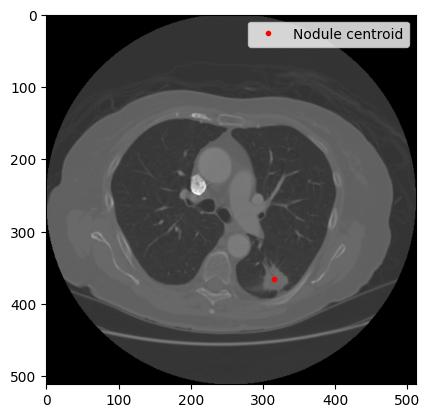

In [22]:
i,j,k = ann.centroid

vol = ann.scan.to_volume()

plt.imshow(vol[:,:,int(k)], cmap=plt.cm.gray)
plt.plot(j, i, '.r', label="Nodule centroid")
plt.legend()
plt.show()

In [23]:
%pip install SimpleITK

Note: you may need to restart the kernel to use updated packages.


In [32]:
path = '/home/inesamorim46/3ano1sem/labiacd/proj_1/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-NA-NA-30178/3000566.000000-NA-03192'


In [39]:
def load_dicom_series(dicom_dir):
    reader = sitk.ImageSeriesReader()
    dicom_filenames = reader.GetGDCMSeriesFileNames(dicom_dir)
    reader.SetFileNames(dicom_filenames)
    image = reader.Execute()
    return image
    

In [41]:
def process_patient(patient_dir, extractor):
    patient_results = []
    #displays the file names in the specified directory tree by traversing the tree either in top-down or bottom-up approach.
    for root, dirs, files in os.walk(patient_dir):
        if files and files[0].endswith('.dcm'):
            try:
                image = load_dicom_series(root)
            except Exception as e:
                print(f"Error while loading DICOM series in {root}: {e}")
                continue

            mask = sitk.Image(image.GetSize(), sitk.sitkUInt8)
            mask.CopyInformation(image)
            mask = sitk.BinaryThreshold(image, lowerThreshold=100, upperThreshold=255)

            image_path = os.path.join(root, 'image.nii.gz')
            mask_path = os.path.join(root, 'mask.nii.gz')
            sitk.WriteImage(image, image_path)
            sitk.WriteImage(mask, mask_path)

            try:
                result = extractor.execute(image_path, mask_path)
                result['series'] = os.path.basename(root)
                patient_results.append(result)
            except Exception as e:
                print(f"Error while extracting characteristics to {root}: {e}")
                continue


        return patient_results


In [45]:
def extract_features_from_patient(patient_dir):
    extractor = featureextractor.RadiomicsFeatureExtractor()
    patient_results = process_patient(patient_dir, extractor)

    df = pd.DataFrame(patient_results)
    return df


In [46]:
patient_dir = '/home/inesamorim46/3ano1sem/labiacd/proj_1/LIDC-IDRI/LIDC-IDRI-0001'

In [48]:
print(extract_features_from_patient(patient_dir))

None
